In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Database and Tester Initialization
from src.utils import Database
from src.execution import Tester

problemId = 2
dataset_db = Database('data/dataset.db')
problem_tb = dataset_db.get_table('problem')
submission_tb = dataset_db.get_table('submission')
testcase_tb = dataset_db.get_table('testcase')

problem = problem_tb.find_one(id=problemId)
title = problem['title']
description = problem['description']
timeout = problem.get('timeout', 1)
memLimit = problem.get('memLimit', 100000)
buggys = submission_tb.find(problemId=problemId, status='buggy')
buggys = {b['id']: b['code'] for b in buggys}
corrects = submission_tb.find(problemId=problemId, status='correct')
corrects = {c['id']: c['code'] for c in corrects}
testcases = testcase_tb.find(problemId=problemId)
testcases = [{'no': t['id'],
                    'input': t['input'],
                    'expect': t['expect'],
                    'hasStdIn': t.get('hasStdIn', False)} 
                    for t in testcases]
print(len(buggys)+len(corrects), len(buggys), len(corrects))

# Set Tester
Tester.init_globals(testcases, timeout, memLimit, title, description)
Tester.clear_cache()

In [ ]:
# Dataset testing
zero_mem = 0
for r_id, r_code in corrects.items():
    try:
        results = Tester.trace(r_code)
        test_hist = Tester.get_test_hist(results)
        if not Tester.is_all_pass(test_hist):
            print(f'Reference {r_id} - Failed')
            # print(r_code)
            # for tc, result in results:
            #     if result.mem_usage <= 0:
            #         print(result.mem_usage)
            #         zero_mem += 1
            break
    except Exception as e:
        print(f'Error in reference {r_id}')
        print(e)
        break

print(zero_mem)

In [ ]:
# Code testing
code = """import sys

def calculate_score(board, points):
    score = 0
    for i in range(len(board)):
        if board[i] == '.':
            score += points[i]
        elif board[i] == 'd':
            score += points[i] * 2
        elif board[i] == 't':
            score += points[i] * 3
    return score
if size < 8 or size > 100:
    max_score = 0
    max_position = 0
else:
    if len(board_config) != size:
        return 'Board configuration does not match the size provided'
    points = list(map(int, points.split()))
    if any((p < 0 or p > 10 ** 5 for p in points)):
        return 'Invalid points for letters'
    word = 'IITMANDI'
    max_score = 0
    max_position = 0
    for i in range(size - len(word) + 1):
        substring = board_config[i:i + len(word)]
        score = calculate_score(substring, points)
        if score > max_score:
            max_score = score
            max_position = i
size = input()
board_config = input().strip()
points = input().strip()
result = run_code(size, board_config, points)
print(result)"""
            
results = Tester.test(code)
print(results.quality_score)
print('code tested')
for tc, result in results:
    # print(f'TC {tc}: {result.status} {result.stdout}')
    for var, data in result.vari_traces.items():
        print(var)
        print(data)

In [ ]:
# Fitness Evaluation
from src.utils import SFParser, StructureFeatures, ETC

buggy = """def search(x, seq):
    if x < seq[0]:
        return 0
    else:
        for i in range(len(seq)-1):
            if x > seq[i] and x <= seq[i+1]:
                return i
        return len(seq)
        
"""

refer = "t = int(input())\nfor i in range(t):\n    P = int(input())\n    static_info = input().split()\n    F = int(static_info[0])\n    missing_pages = set(map(int, static_info[1:]))\n    T = int(input())\n    total_sum = P * (P + 1) / 2\n    sum_missing_pages = sum(page for page in missing_pages)\n    remaining_pages_sum = total_sum - sum_missing_pages\n    leaves_torn = T\n    remaining_pages = [page for page in range(1, P + 1) if page not in missing_pages and ((page + 1) // 2 not in range(leaves_torn))]\n    total_remaining_sum = sum(remaining_pages)\n    total_leaves = (P + 1) // 2\n    probability_not_torn_leaf = max(0, total_leaves - leaves_torn) / total_leaves\n    expected_sum = remaining_pages_sum * probability_not_torn_leaf\n    print(f\"{expected_sum:.4f}\")"

patch = "t = int(input())\nfor i in range(t):\n    P = int(input())\n    static_info = input().split()\n    F = int(static_info[0])\n    missing_pages = set(map(int, static_info[1:]))\n    T = int(input())\n    total_sum = P * (P + 1) / 2\n    sum_missing_pages = sum(page for page in missing_pages)\n    remaining_pages_sum = total_sum - sum_missing_pages\n    leaves_torn = T\n    remaining_pages = [page for page in range(1, P + 1) if page not in missing_pages and ((page + 1) // 2 not in range(leaves_torn))]\n    total_remaining_sum = sum(remaining_pages)\n    total_leaves = (P + 1) // 2\n    probability_not_torn_leaf = max(0, total_leaves - leaves_torn) / total_leaves\n    expected_sum = remaining_pages_sum * probability_not_torn_leaf\n    print(f\"{expected_sum:.4f}\")"

    
def fitness(code):
    # Readability
    sfp = SFParser()
    features = sfp.run(code)
    weights = StructureFeatures.get_weights(features)
    readability = sum([s * weights[f] for f, s in features.items()])
    
    # Efficiency (Memory and Runtime)
    results = Tester.trace(code)
    mem_usage, runtime = 0, 0
    for _, result in results:
        if result.status == "Success":
            mem_usage += result.mem_usage
            runtime += result.runtime
        else:
            mem_usage += Tester.memLimit
            runtime += Tester.timeout
    mem_usage = ETC.divide(mem_usage, len(results))
    runtime = ETC.divide(runtime, len(results))
    
    # Maintainability
    maintainability = results.maintain_score
    
    # Quality
    quality = results.quality_score
    
    # test_results = Tester.print_test_results(results)
    # print(test_results)
    warning_messages = results.get_warning()
    print(warning_messages)
    print()
    
    return readability, mem_usage, runtime, maintainability, quality


b_readability, b_mem_usage, b_runtime, b_maintainability, b_quality = fitness(buggy)
r_readability, r_mem_usage, r_runtime, r_maintainability, r_quality = fitness(refer)
f_readability, f_mem_usage, f_runtime, f_maintainability, f_quality = fitness(patch)

print(b_mem_usage, r_mem_usage, f_mem_usage)
print(b_runtime, r_runtime, f_runtime)
print(b_readability, r_readability, f_readability)
print(b_maintainability, r_maintainability, f_maintainability)
print()
print(f'Memory Usage Decrease : refer::{b_mem_usage >= r_mem_usage} patch:{b_mem_usage >= f_mem_usage}')
print(f'Runtime Decrease      : refer:{b_runtime >= r_runtime} patch:{b_runtime >= f_runtime}')
print(f'Readability Improved  : refer:{b_readability >= r_readability} patch:{b_readability >= f_readability}')
print(f'Maintenance Improved  : refer:{b_maintainability <= r_maintainability} patch:{b_maintainability <= f_maintainability}')
print(f'Quality Improved      : refer:{b_quality <= r_quality} patch:{b_quality <= f_quality}')

_________________________

In [22]:
from src.utils import Database, DBKey, TinyDatabase
from sqlalchemy import MetaData, Table, Column, Integer, String, ForeignKey, Boolean
from dataset import connect

# 1. SQLAlchemy 메타데이터로 테이블 스키마 정의
metadata = MetaData()

problem = Table(
    'problem', metadata,
    Column('id', Integer, primary_key=True),
    Column(DBKey.title, String, nullable=False),
    Column(DBKey.description, String, nullable=False),
    Column('timeout', Integer, default=1, nullable=False),  # 초 단위
    Column('memLimit', Integer, default=100000, nullable=False),  # 메모리 제한 (KB 단위)
)

submission = Table(
    'submission', metadata,
    Column('id', Integer, primary_key=True),
    Column(DBKey.problemId, Integer, ForeignKey('problem.id')),  # 외래키 참조
    Column('code', String),
    Column('status', String)  # 'correct' 또는 'buggy' 등
)

testcase = Table(
    'testcase', metadata,
    Column('id', Integer, primary_key=True),
    Column(DBKey.problemId, Integer, ForeignKey('problem.id')),  # 외래키 참조
    Column('input', String),
    Column('expect', String),
    Column('hasStdIn', Boolean, default=False),  # 표준 입력 여부
)

results = Table(
    'results', metadata,
    Column('id', Integer, primary_key=True),
    Column(DBKey.problemId, Integer, ForeignKey('problem.id')),  # 외래키 참조
    Column(DBKey.fitness, String),
    Column(DBKey.generations, String),
    Column(DBKey.pop_size, String),
    Column(DBKey.selection, String),
    Column(DBKey.trials, Integer),
    Column(DBKey.b_progs, Integer),
    Column(DBKey.solutions, Integer),
    Column(DBKey.rr, Integer),
    Column(DBKey.rps, Integer),
    Column(DBKey.att, Integer),
    Column(DBKey.f1, Integer),
    Column(DBKey.f2, Integer),
    Column(DBKey.f3, Integer),
    Column(DBKey.f4, Integer),
    Column(DBKey.f5, Integer),
    Column(DBKey.f6, Integer),
    Column(DBKey.f7, Integer),
)

experiments = Table(
    'experiments', metadata,
    Column('id', Integer, primary_key=True),
    Column(DBKey.problemId, Integer, ForeignKey('problem.id')),  # 외래키 참조
    Column(DBKey.title, String),
    Column(DBKey.fitness, String),
    Column(DBKey.generations, Integer),
    Column(DBKey.pop_size, Integer),
    Column(DBKey.selection, String),
    Column(DBKey.trials, Integer),
    Column(DBKey.b_progs, Integer),
    Column(DBKey.a_sol, Integer),
    Column(DBKey.a_rr, Integer),
    Column(DBKey.a_rps, Integer),
    Column(DBKey.a_att, Integer),
    Column(DBKey.f1, Integer),
    Column(DBKey.f2, Integer),
    Column(DBKey.f3, Integer),
    Column(DBKey.f4, Integer),
    Column(DBKey.f5, Integer),
    Column(DBKey.f6, Integer),
    Column(DBKey.f7, Integer),
)

# 2. dataset으로 DB 연결 후, SQLAlchemy 엔진을 통해 테이블 생성
db = connect('sqlite:///data2/dataset.db')
# SQLite에서는 외래키 제약을 활성화해야 합니다
db.engine.execute("PRAGMA foreign_keys = ON")  # SQLite 외래키 활성화 :contentReference[oaicite:1]{index=1}
metadata.create_all(db.engine)

# # 3. 이제 dataset으로도 동일한 테이블을 다룰 수 있습니다
# problem_tb = db['problem']
# submission_tb = db['submission']
# testcase_tb = db['testcase']

# for shorts in ['1', '2', '3', '4', '5', '6', '7']:
#     db = TinyDatabase(f'data/{shorts}/dataset.json')
#     problem = db.get_data_from_table('problem')
#     title = problem['title']
#     description = problem['description']
#     references = db.get_data_from_table('references')
#     buggys = db.get_data_from_table('buggys')
#     testcases = db.table('testcases').all()
    
#     problemId = problem_tb.insert({'title': title, 'description': description, 'timeout': 1, 'memLimit': 1000000})
#     corrects = [{'problemId':problemId, 'code': v, 'status':'correct'} for v in references.values()]
#     buggys = [{'problemId':problemId, 'code': v, 'status':'buggy'} for v in buggys.values()]
#     submissions = corrects + buggys
#     submission_tb.insert_many(submissions)
#     testcases = [{'problemId': problemId, 'input': tc['input'], 'expect': tc['expect'], 'hasStdIn': tc.get('hasKeyboardInput', False)} for tc in testcases]
#     testcase_tb.insert_many(testcases)

In [ ]:
import numpy as np
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.optimize import minimize

class MOO(Problem):
    def __init__(self, scores: dict):
        self.keys = list(scores.keys())
        self.values = list(scores.values())
        self.n_obj = len(scores[self.keys[0]])
        self.fitness = np.array([scores[k] for k in self.keys], dtype=float)
        
        # set number of variables equal to number of objectives
        n_var = self.n_obj
        xl = np.array([min(self.fitness[:, i]) for i in range(self.n_obj)])
        xu = np.array([max(self.fitness[:, i]) for i in range(self.n_obj)])
        
        super().__init__(
            n_var=n_var,
            n_obj=self.n_obj,
            n_constr=0,
            xl=xl,
            xu=xu,
            elementwise_evaluation=False
        )
    
    def _evaluate(self, X, out, *args, **kwargs):
        dists = np.linalg.norm(self.fitness[None, :, :] - X[:, None, :], axis=2)
        idx = np.argmin(dists, axis=1)
        F = self.fitness[idx]
        out['F'] = -F

def moead(scores: dict, pop_size: int, factory: str = "energy", ensure_exact_count: bool = True) -> list:
    """
    MOEAD Selection
    
    Args:
        scores: 점수 딕셔너리
        pop_size: 선택할 해의 개수
        factory: reference directions 생성 방식
        ensure_exact_count: True이면 정확히 pop_size 개의 해를 반환
    """
    # Set Problem
    problem = MOO(scores)
    
    # 방법 1: 더 많은 reference directions 생성하여 중복 가능성 줄이기
    if ensure_exact_count:
        # pop_size보다 더 많은 reference directions 생성
        adjusted_pop_size = min(pop_size * 3, len(scores))  # 최대 전체 해의 개수까지
        ref_dirs = get_reference_directions(factory, problem.n_obj, n_points=adjusted_pop_size)
    else:
        ref_dirs = get_reference_directions(factory, problem.n_obj, n_points=pop_size)
    
    # print(f"요청한 pop_size: {pop_size}")
    # print(f"실제 생성된 reference directions 수: {len(ref_dirs)}")
    
    algo = MOEAD(ref_dirs, n_offsprings=pop_size)
    res = minimize(problem, algo, verbose=False)
    X = res.X
    dists = np.linalg.norm(problem.fitness[None, :, :] - X[:, None, :], axis=2)
    idxs = np.argmin(dists, axis=1)
    samples = [problem.keys[i] for i in idxs]
    return samples[:pop_size]  # pop_size 개의 해를 반환
    # optimal_fitness_values = res.F
    # # print(f"MOEAD가 선택한 해의 수: {len(optimal_fitness_values)}")
    
    # # problem 객체에서 모든 해의 fitness 값과 키를 가져옵니다.
    # all_fitness_vectors = problem.fitness
    # all_keys = problem.keys
    
    # # 선택된 키들을 저장할 리스트 (순서 보존, 중복 허용)
    # selected_keys_with_duplicates = []
    # selected_keys_unique = set()
    
    # # 최적 해 집합에 있는 각 해에 대해 반복합니다.
    # for optimal_f in optimal_fitness_values:
    #     # res.F 값은 -1이 곱해진 상태이므로, 다시 -1을 곱해 원래 fitness 값과 비교할 수 있도록 합니다.
    #     target_fitness = -optimal_f
        
    #     # 부동소수점 비교를 위해 np.isclose를 사용하여 target_fitness와 일치하는 행을 찾습니다.
    #     match_indices = np.where(np.all(np.isclose(all_fitness_vectors, target_fitness), axis=1))[0]
        
    #     # 일치하는 인덱스가 있다면
    #     if len(match_indices) > 0:
    #         # 첫 번째 일치하는 인덱스를 사용합니다.
    #         idx = match_indices[0]
    #         key = all_keys[idx]
    #         selected_keys_with_duplicates.append(key)
    #         selected_keys_unique.add(key)
    
    # # print(f"중복 포함 선택된 해: {selected_keys_with_duplicates}")
    # # print(f"고유한 선택된 해: {list(selected_keys_unique)}")
    
    # # 정확히 pop_size 개의 해를 보장하는 로직
    # if ensure_exact_count:
    #     unique_selected = list(selected_keys_unique)
        
    #     if len(unique_selected) >= pop_size:
    #         # 충분한 해가 선택된 경우, pop_size 개만 반환
    #         return unique_selected[:pop_size]
    #     else:
    #         # 부족한 경우, 추가 해를 선택
    #         remaining_keys = [k for k in all_keys if k not in selected_keys_unique]
            
    #         if len(remaining_keys) > 0:
    #             # 남은 해들 중에서 다양성을 고려하여 추가 선택
    #             additional_needed = pop_size - len(unique_selected)
                
    #             # 다양성을 고려한 추가 선택
    #             remaining_fitness = np.array([scores[k] for k in remaining_keys])
    #             selected_fitness = np.array([scores[k] for k in unique_selected])
                
    #             # 이미 선택된 해들과 가장 다른 해들을 우선적으로 선택
    #             distances = []
    #             for i, remaining_key in enumerate(remaining_keys):
    #                 remaining_f = remaining_fitness[i]
    #                 min_dist = np.min(np.linalg.norm(selected_fitness - remaining_f, axis=1))
    #                 distances.append((min_dist, remaining_key))
                
    #             # 거리 기준으로 정렬하여 가장 다른 해들부터 선택
    #             distances.sort(reverse=True)
    #             additional_keys = [key for _, key in distances[:additional_needed]]
                
    #             final_selection = unique_selected + additional_keys
    #             # print(f"추가 선택된 해: {additional_keys}")
    #             return final_selection[:pop_size]
    #         else:
    #             # 모든 해가 이미 선택된 경우
    #             return unique_selected
    # else:
    #     return list(selected_keys_unique)

# 테스트 코드
scores = {
    "pop_2": [0.5, 0.7],
    "pop_3": [0.3, 0.4],
    "pop_1": [0.8, 0.8],
    "pop_4": [0.2, 0.6],
    "pop_5": [0.6, 0.3],
    "pop_6": [0.4, 0.5],
    "pop_7": [0.9, 0.2],
    "pop_8": [0.1, 0.9],
    "pop_9": [0.7, 0.1],
    "pop_10": [0.3, 0.8],
    "pop_11": [0.4, 0.2],
}

# print("=== 정확히 pop_size 개 보장 ===")
selected = moead(scores, pop_size=5, factory="das-dennis", ensure_exact_count=True)
print("Selected solutions:", selected)
# print(f"선택된 해의 최종 개수: {len(selected)}")

In [ ]:
import builtins
import numpy as np
import pandas as pd

from paretoset import paretoset
from pymoo.core.problem import Problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.algorithms.moo.nsga3 import NSGA3 as GA
from pymoo.optimize import minimize
from pymoo.util.hv import hv
from src.utils import Randoms

class MOO(Problem):
    def __init__(self, scores: dict):
        self.keys = list(scores.keys())
        self.n_obj = len(scores[self.keys[0]])
        self.fitness = np.array([scores[k] for k in self.keys], dtype=float)
        # set number of variables equal to number of objectives
        n_var = self.n_obj
        xl = np.array([min(self.fitness[:, i]) for i in range(self.n_obj)])
        xu = np.array([max(self.fitness[:, i]) for i in range(self.n_obj)])

        super().__init__(
            n_var=n_var,
            n_obj=self.n_obj,
            n_constr=0,
            xl=xl,
            xu=xu,
            elementwise_evaluation=False
        )

    def _evaluate(self, X, out, *args, **kwargs):
        dists = np.linalg.norm(self.fitness[None, :, :] - X[:, None, :], axis=2)
        idx = np.argmin(dists, axis=1)
        F = self.fitness[idx]
        out['F'] = -F

class NSGA3(GA):
    def __init__(self, *args, **kwargs):
        _orig_print = builtins.print
        builtins.print = lambda *a, **k: None
        try:
            super().__init__(*args, **kwargs)
        finally:
            # Restore the original print
            builtins.print = _orig_print
            
def selection(scores:dict, pop_size: int) -> list[str]:
    problem = MOO(scores)
    
    # Non-dominated Sorting
    scores_df = pd.DataFrame.from_dict(scores, orient='index')
    pareto_set = paretoset(scores_df, sense=["max"] * len(scores_df.columns))
    fronts = scores_df[pareto_set].index.tolist()
    scores = {k: scores[k] for k in fronts}  # 비지배 해만 남김
    
    # NSGA3 Selection
    ## Set Problem
    # problem = MOO(scores)
    
    ## Set Reference directions
    M = problem.n_obj          # 목표 함수 개수
    N = pop_size                        # 해의 개수
    H = int(np.ceil(N ** (1 / (M-1))))  # 파티션 수
    ref_dirs = get_reference_directions("das-dennis", M, n_partitions=H)
    
    ## Set NSGA3 Algorithm
    algorithm = NSGA3(ref_dirs=ref_dirs, n_offsprings=pop_size)
    
    ## Run Optimization
    res = minimize(problem, algorithm, verbose=False)
    X = res.X
    dists = np.linalg.norm(problem.fitness[None, :, :] - X[:, None, :], axis=2)
    idxs = np.argmin(dists, axis=1)
    samples = [problem.keys[i] for i in idxs]
    if len(samples) < pop_size:
        adds = Randoms.sample(list(scores.keys()), pop_size-len(samples))
        samples.extend(adds)
    return samples

def hype(scores: dict, pop_size: int) -> list[str]:
    scores = {k: [1-v for v in values] for k, values in scores.items()}
    F = np.array([score for score in scores.values()], dtype=float)
    
    hv_values = {}
    ref_point = np.array([1.0] * F.shape[1])
    for key, value in scores.items():
        hv_values[key] = hv(ref_point=ref_point, F=np.array([value]))
    
    sorted_keys = sorted(hv_values, key=hv_values.get, reverse=True)
    return sorted_keys[:pop_size]
    

# 예시 사용법
if __name__ == "__main__":
    scores = {
        'A': {'f1': 1, 'f2': 1, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 50},
        'D': {'f1': 0.2, 'f2': 0.5, 'f3': 0.1, 'f4': 0.2, 'f5': 0.3, 'f6': 0.4, 'f7': 50},
        'B': {'f1': 0.4, 'f2': 1, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'C': {'f1': 2, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'D': {'f1': 3, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'E': {'f1': 4, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'F': {'f1': 5, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'G': {'f1': 6, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'H': {'f1': 7, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'I': {'f1': 8, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
        'J': {'f1': 9, 'f2': 0.5, 'f3': 1, 'f4': 1, 'f5': 1, 'f6': 1, 'f7': 100},
    }
    scores = {key: list(value.values()) for key, value in scores.items()}

    # selected = selection(scores, pop_size=5)
    
    selected = hype(scores, pop_size=5)
    
    
    print("Selected programs:", selected)

In [ ]:
import numpy as np
from pymoo.optimize import minimize
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.moead import MOEAD
from pymoo.algorithms.moo.nsga3 import NSGA3

class MOO(Problem):
    def __init__(self, scores: dict):
        self.keys = list(scores.keys())
        self.n_obj = len(scores[self.keys[0]])
        self.fitness = np.array([scores[k] for k in self.keys], dtype=float)
        
        # 변수 개수를 목표 함수 개수와 같게 설정
        n_var = self.n_obj
        xl = np.array([0.0] * self.n_obj)
        xu = np.array([1.0] * self.n_obj)
        
        super().__init__(
            n_var=n_var,
            n_obj=self.n_obj,
            n_constr=0,
            xl=xl,
            xu=xu,
            elementwise_evaluation=False
        )
    
    def _evaluate(self, X, out, *args, **kwargs):
        # 각 해 X에 대해 가장 가까운 실제 점 찾기
        dists = np.linalg.norm(self.fitness[None, :, :] - X[:, None, :], axis=2)
        idx = np.argmin(dists, axis=1)
        F = self.fitness[idx]
        
        # 최소화 문제로 변환 (음수 부호 제거하고 정규화 고려)
        out['F'] = -F


class Selection:
    def nsga3(self, scores: dict, pop_size: int, factory: str = "energy") -> list:
        # Set Problem
        problem = MOO(scores)
        
        ## Set Reference directions
        M = problem.n_obj                   # 목표 함수 개수
        N = pop_size                        # 해의 개수
        H = int(np.ceil(N ** (1 / (M-1))))  # 파티션 수
        if factory == "das-dennis":
            ref_dirs = get_reference_directions(factory, M, n_partitions=H)
        elif factory == "energy":
            ref_dirs = get_reference_directions(factory, M, n_points=pop_size)
        
        algo = NSGA3(ref_dirs, n_offsprings=pop_size)
        res = minimize(problem, algo, verbose=False)
        X_pop = res.pop.get("X")
        
        selected = []
        used_indices = set()
        for x in X_pop:
            # 각 X에 대해 fitness 행렬과의 L2 거리 계산
            dists = np.linalg.norm(problem.fitness - x, axis=1)
            # 이미 선택된 인덱스가 아닌 것 중에서 최소 거리 선택
            available_indices = [i for i in range(len(dists)) if i not in used_indices]
            if not available_indices:
                # 모든 인덱스가 사용된 경우 전체에서 선택
                available_indices = list(range(len(dists)))
            # 사용 가능한 인덱스 중에서 최소 거리
            min_idx = min(available_indices, key=lambda i: dists[i])
            used_indices.add(min_idx)
            key = problem.keys[min_idx]
            selected.append(key)
        return selected[:pop_size]
            
        
    def moead(self, scores:dict, pop_size:int, factory:str="energy") -> list:
        # Set Problem
        problem = MOO(scores)
        
        ## Set Reference directions
        M = problem.n_obj                   # 목표 함수 개수
        N = pop_size                        # 해의 개수
        H = int(np.ceil(N ** (1 / (M-1))))  # 파티션 수
        if factory == "das-dennis":
            ref_dirs = get_reference_directions(factory, M, n_partitions=H)
        elif factory == "energy":
            ref_dirs = get_reference_directions(factory, M, n_points=pop_size)
        
        algo = MOEAD(ref_dirs, n_offsprings=pop_size)
        res = minimize(problem, algo, verbose=False)
        X_pop = res.pop.get("X")
        
        selected = []
        used_indices = set()
        for x in X_pop:
            # 각 X에 대해 fitness 행렬과의 L2 거리 계산
            dists = np.linalg.norm(problem.fitness - x, axis=1)
            # 이미 선택된 인덱스가 아닌 것 중에서 최소 거리 선택
            available_indices = [i for i in range(len(dists)) if i not in used_indices]
            if not available_indices:
                # 모든 인덱스가 사용된 경우 전체에서 선택
                available_indices = list(range(len(dists)))
            # 사용 가능한 인덱스 중에서 최소 거리
            min_idx = min(available_indices, key=lambda i: dists[i])
            used_indices.add(min_idx)
            key = problem.keys[min_idx]
            selected.append(key)
        return selected[:pop_size]
    
    def analyze_diversity(self, scores: dict, selected: list) -> dict:
        """선택된 해들의 다양성 분석"""
        if not selected:
            return {"diversity": 0, "coverage": 0}
        
        # 선택된 해들의 목표 함수 값들
        selected_scores = np.array([scores[key] for key in selected])
        all_scores = np.array(list(scores.values()))
        
        # 다양성 측정 (선택된 해들 간의 평균 거리)
        if len(selected_scores) > 1:
            pairwise_dists = []
            for i in range(len(selected_scores)):
                for j in range(i+1, len(selected_scores)):
                    dist = np.linalg.norm(selected_scores[i] - selected_scores[j])
                    pairwise_dists.append(dist)
            diversity = np.mean(pairwise_dists)
        else:
            diversity = 0
        
        # 커버리지 측정 (전체 해 공간에서 선택된 해들의 분포)
        if len(all_scores) > 1:
            # 전체 해 공간의 범위
            ranges = np.ptp(all_scores, axis=0)  # 각 목표에 대한 범위
            selected_ranges = np.ptp(selected_scores, axis=0)  # 선택된 해들의 범위
            coverage = np.mean(selected_ranges / (ranges + 1e-10))  # 0으로 나누기 방지
        else:
            coverage = 1.0
        
        return {
            "diversity": diversity,
            "coverage": coverage,
            "selected_count": len(selected),
            "total_count": len(scores)
        }

# 테스트 데이터
scores = {
    'A': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    'B': [0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2],
    'C': [0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3],
    'D': [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4],
    'E': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
    'F': [0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6],
    'G': [0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7],
    'H': [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
    'I': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
    'J': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
}

# 더 다양한 테스트 데이터
diverse_scores = {
    'A': [0.1, 0.9, 0.1, 0.9, 0.1, 0.9, 0.1],
    'B': [0.9, 0.1, 0.9, 0.1, 0.9, 0.1, 0.9],
    'C': [0.5, 0.5, 0.1, 0.1, 0.9, 0.9, 0.5],
    'D': [0.2, 0.8, 0.3, 0.7, 0.4, 0.6, 0.5],
    'E': [0.8, 0.2, 0.7, 0.3, 0.6, 0.4, 0.5],
    'F': [0.1, 0.1, 0.5, 0.5, 0.9, 0.9, 0.1],
    'G': [0.3, 0.3, 0.7, 0.7, 0.2, 0.2, 0.8],
    'H': [0.6, 0.4, 0.2, 0.8, 0.1, 0.9, 0.5],
    'I': [0.4, 0.6, 0.8, 0.2, 0.9, 0.1, 0.5],
    'J': [0.7, 0.3, 0.4, 0.6, 0.5, 0.5, 0.9]
}

# 테스트 실행
selector = Selection()

print("=== 균등한 데이터 테스트 ===")
selected = selector.nsga3(scores, pop_size=5, factory="energy")
print("Selected programs:", selected)
analysis = selector.analyze_diversity(scores, selected)
print("Diversity analysis:", analysis)

print("\n=== 다양한 데이터 테스트 ===")
selected_diverse = selector.nsga3(diverse_scores, pop_size=5, factory="energy")
print("Selected programs:", selected_diverse)
analysis_diverse = selector.analyze_diversity(diverse_scores, selected_diverse)
print("Diversity analysis:", analysis_diverse)

print("\n\n=== 균등한 데이터 테스트 ===")
selected = selector.nsga3(scores, pop_size=5, factory="das-dennis")
print("Selected programs:", selected)
analysis = selector.analyze_diversity(scores, selected)
print("Diversity analysis:", analysis)

print("\n=== 다양한 데이터 테스트 ===")
selected_diverse = selector.nsga3(diverse_scores, pop_size=5, factory="das-dennis")
print("Selected programs:", selected_diverse)
analysis_diverse = selector.analyze_diversity(diverse_scores, selected_diverse)
print("Diversity analysis:", analysis_diverse)

In [ ]:
from src.utils import Database
from src.utils import Randoms

overall = {}
db = Database('data/dataset.db')
problem_tb = db.get_table('problem')
problems = list(problem_tb.find())
Randoms.shuffle(problems)
print(problems)

In [44]:
from src.utils import Database

overall = {}
db = Database('data2/dataset.db')
experiments = db.get_table('experiments')

for exp in experiments.all():
    problemId = exp['problemId']
    generations = exp['generations']
    selection = exp['selection']
    overall.setdefault(problemId, {})
    overall[problemId].setdefault(generations, {})
    overall[problemId][generations].setdefault(selection, {})
    
    rr = exp['avg_rr']
    rps = exp['avg_rps']
    att = exp['avg_att']
    f1 = exp['f1']
    f2 = exp['f2']
    f3 = exp['f3']
    f4 = exp['f4']
    f5 = exp['f5']
    f6 = exp['f6']
    f7 = exp['f7']
    overall[problemId][generations][selection] = {
        'rr': rr, 'rps': rps, 'att': att,
        'fitness': {'f1': f1, 'f2': f2, 'f3': f3,
        'f4': f4, 'f5': f5, 'f6': f6, 'f7': f7}
    }

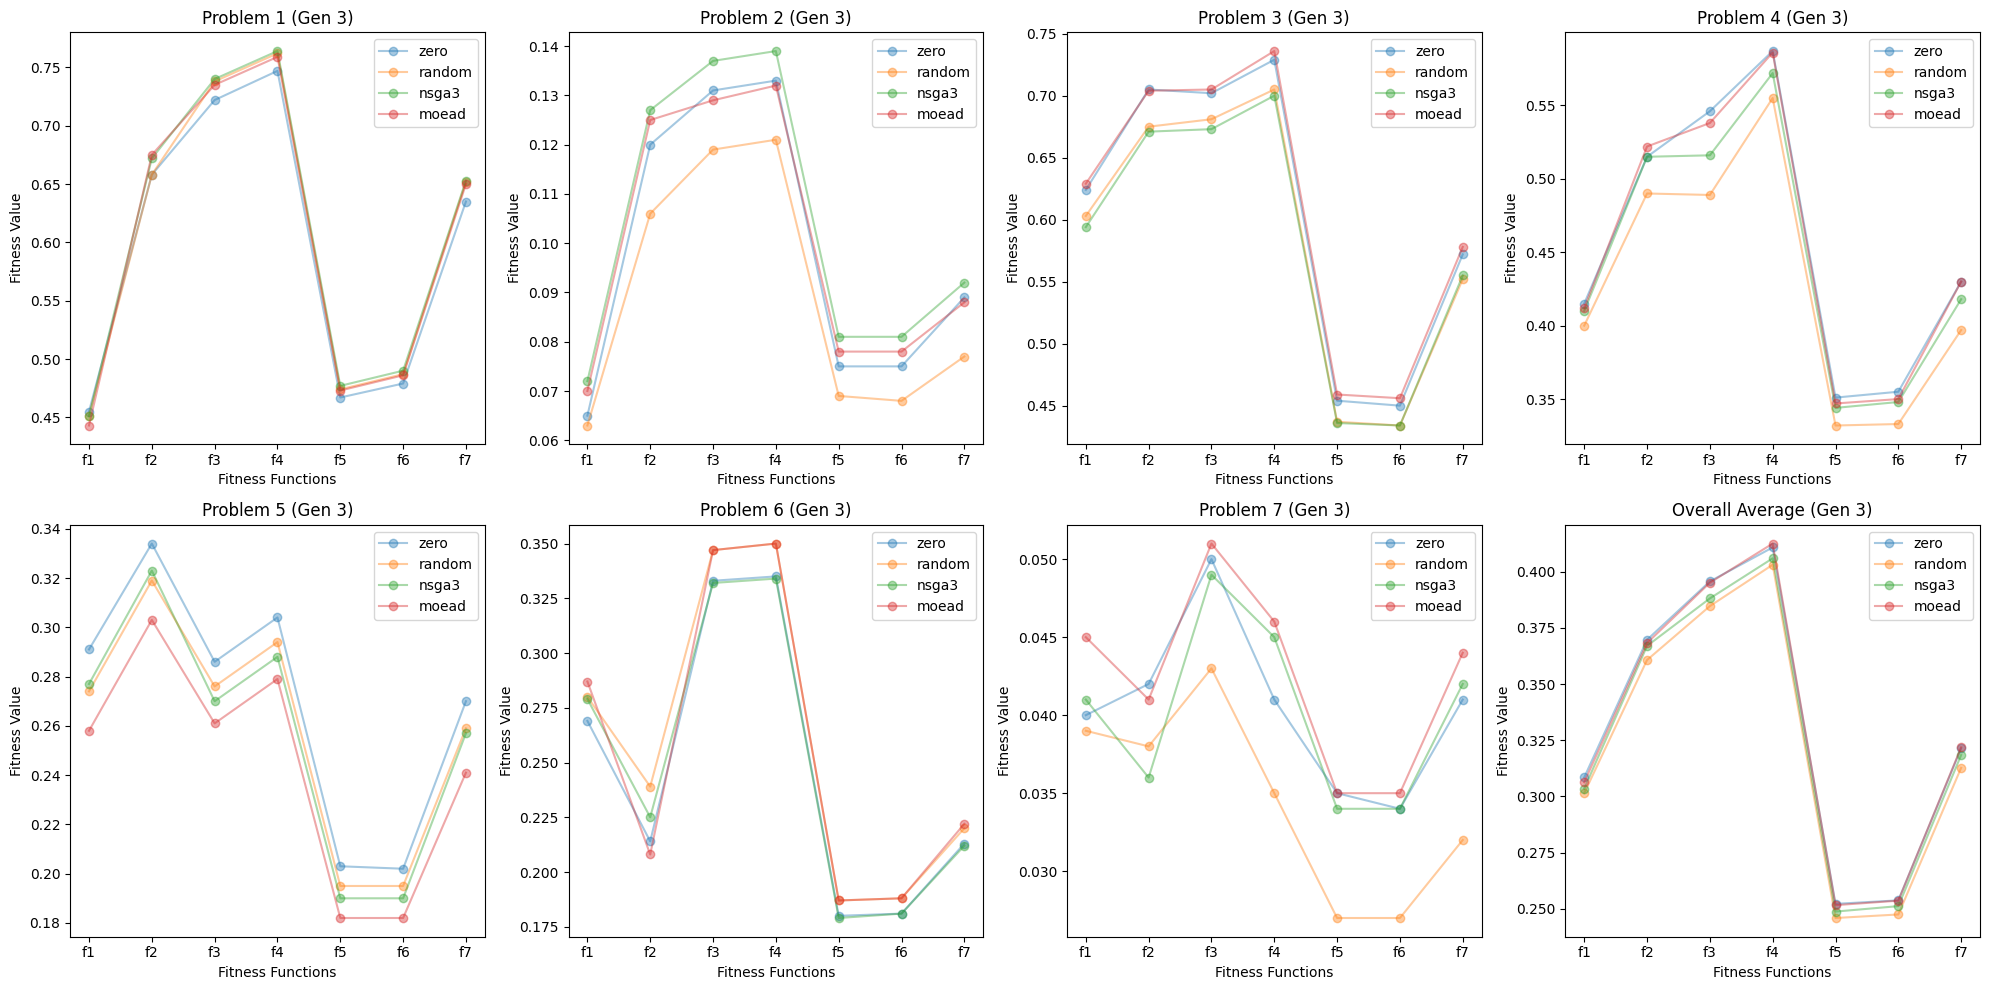

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


TARGET_GENERATION = 3
methods = ['zero', 'random', 'nsga3', 'moead']

# 데이터 전처리
problemIds = sorted(overall.keys())
num_problems = len(problemIds)

# subplot 설정 (2행 4열)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

# 각 problemId별 subplot 생성
for i, problemId in enumerate(problemIds):
    ax = axes[i]
    
    # TARGET_GENERATION이 해당 problemId에 존재하는지 확인
    if TARGET_GENERATION not in overall[problemId]:
        ax.set_title(f'Problem {problemId} (No data for gen {TARGET_GENERATION})')
        ax.text(0.5, 0.5, f'No data for\ngeneration {TARGET_GENERATION}', 
                ha='center', va='center', transform=ax.transAxes)
        continue
    
    # 각 selection별로 선 그리기
    for j, selection in enumerate(methods):
        if selection not in overall[problemId][TARGET_GENERATION]:
            continue
        fitness_data = overall[problemId][TARGET_GENERATION][selection]['fitness']
        fitness_values = [
            fitness_data['f1'], fitness_data['f2'], fitness_data['f3'],
            fitness_data['f4'], fitness_data['f5'], fitness_data['f6'],
            fitness_data['f7']
        ]
        
        # 선 그리기
        x_labels = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
        ax.plot(x_labels, fitness_values, marker='o', label=selection, alpha=0.4)
    
    ax.set_title(f'Problem {problemId} (Gen {TARGET_GENERATION})')
    ax.set_xlabel('Fitness Functions')
    ax.set_ylabel('Fitness Value')
    ax.legend()

# 마지막 subplot에 전체 평균 그리기
if num_problems < len(axes):
    ax = axes[num_problems]
    
    # 모든 problemId에서 TARGET_GENERATION의 selection별 평균 계산
    selection_averages = defaultdict(list)
    
    for problemId in problemIds:
        if TARGET_GENERATION in overall[problemId]:
            for selection in methods:
                fitness_data = overall[problemId][TARGET_GENERATION][selection]['fitness']
                fitness_values = [
                    fitness_data['f1'], fitness_data['f2'], fitness_data['f3'],
                    fitness_data['f4'], fitness_data['f5'], fitness_data['f6'],
                    fitness_data['f7']
                ]
                selection_averages[selection].append(fitness_values)
    
    # 각 selection별 전체 평균 계산 및 그리기
    x_labels = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
    for j, (selection, values) in enumerate(selection_averages.items()):
        if values:  # 데이터가 있는 경우에만
            overall_avg = np.mean(values, axis=0)
            ax.plot(x_labels, overall_avg, marker='o', label=selection, alpha=0.4)
    
    ax.set_title(f'Overall Average (Gen {TARGET_GENERATION})')
    ax.set_xlabel('Fitness Functions')
    ax.set_ylabel('Fitness Value')
    ax.legend()

# 사용하지 않는 subplot 숨기기
for i in range(num_problems + 1, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

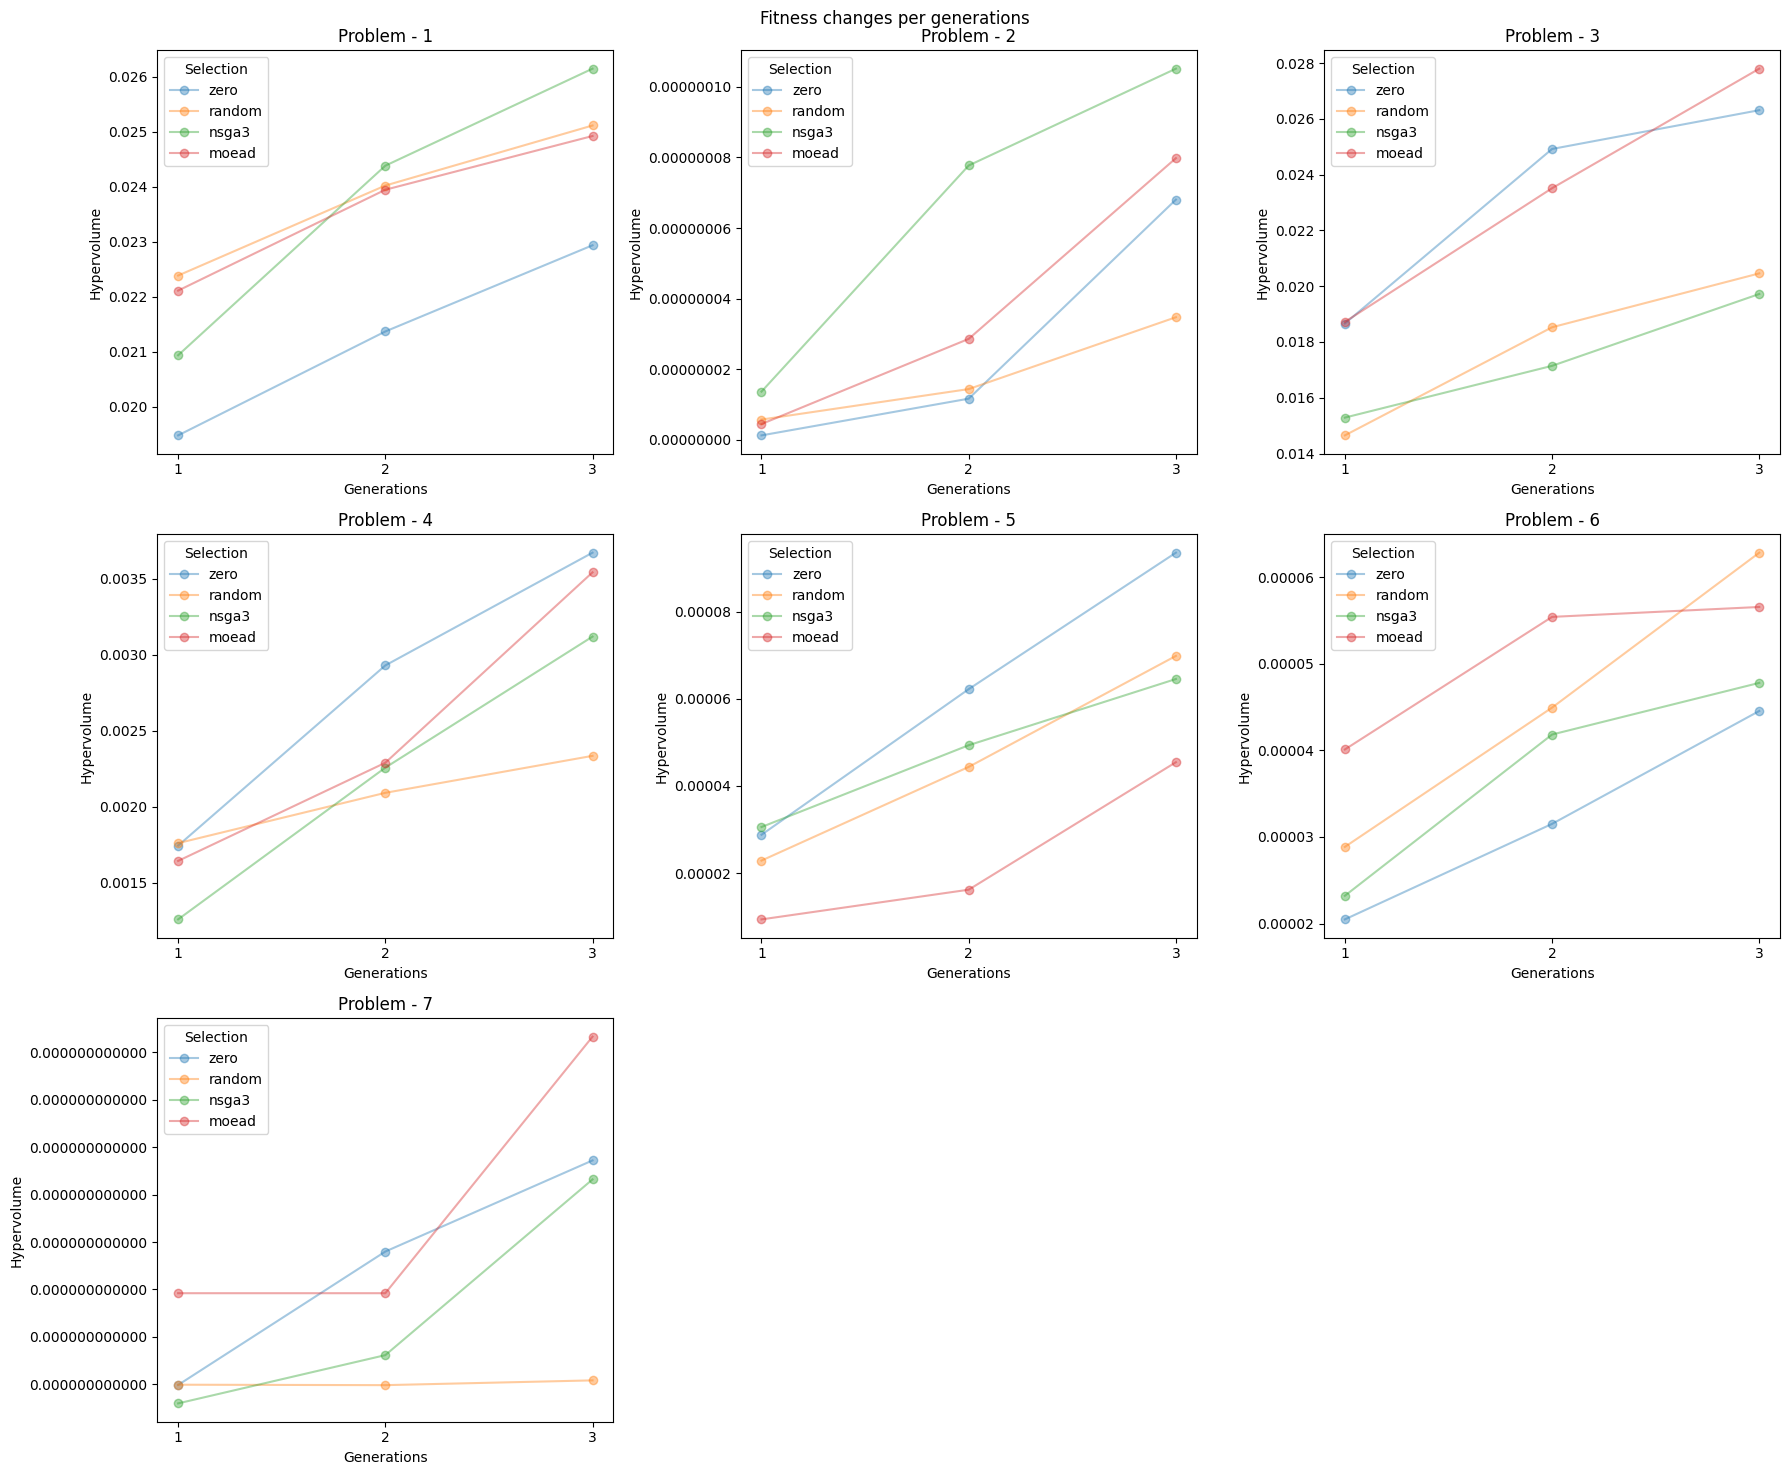

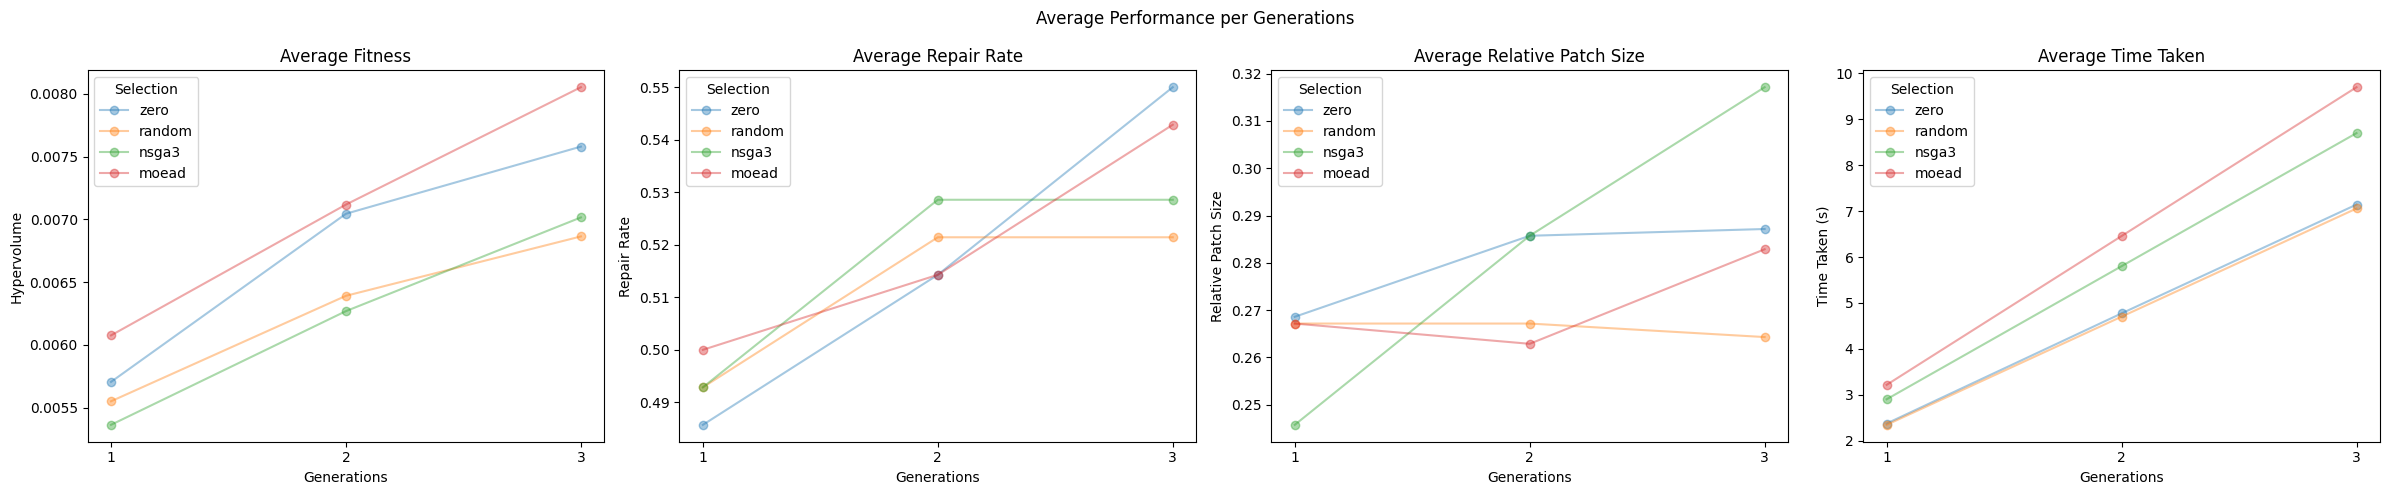

In [51]:
from src.genetic import Selection
from pymoo.util.hv import hv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

methods = ['zero', 'random', 'nsga3', 'moead']


# 1) 문제별 세대별 선택기별 fitness & performance 계산
fitness = {}
repair_rate = {}
relative_patch_size = {}
average_time_taken = {}
selector = Selection()
for problemId, generations_data in overall.items():
    fitness.setdefault(problemId, {})
    repair_rate.setdefault(problemId, {})
    relative_patch_size.setdefault(problemId, {})
    average_time_taken.setdefault(problemId, {})
    for generations, selections in generations_data.items():
        scores = {sel: values['fitness'] for sel, values in selections.items()}
        evaluates = {s:0 for s in methods}
        # HV evaluation
        scores = {sel: [1-v for v in values.values()] for sel, values in scores.items()}
        F = np.array([score for score in scores.values()], dtype=float)
        ref_point = np.array([1.0] * F.shape[1])
        for sel, value in scores.items():
            evaluates[sel] = hv(ref_point=ref_point, F=np.array([value]))
        # RankSum evaluation
        # df = pd.DataFrame.from_dict(scores, orient='index')
        # ranks = df.rank(method='min', ascending=False)
        # rank_sums = ranks.sum(axis=1)
        # for k, v in rank_sums.items():
        #     evaluates[k] = v
        fitness[problemId][generations] = evaluates
        repair_rate[problemId][generations] = {
            sel: value['rr'] for sel, value in selections.items()
        }
        relative_patch_size[problemId][generations] = {
            sel: value['rps'] for sel, value in selections.items()
        }
        average_time_taken[problemId][generations] = {
            sel: value['att'] for sel, value in selections.items()
        }


# 2) problemId 별 꺽은선 그래프
n_problems = len(fitness)
n_cols = 3
n_rows = (n_problems + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows), squeeze=False)
problem_ids = list(fitness.keys())
for idx, problemId in enumerate(problem_ids):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col]
    ax.yaxis.get_major_formatter().set_useOffset(False)
    
    gen_dict = fitness[problemId]
    gens = sorted(gen_dict.keys())
    for sel in methods:
        y = [gen_dict[g].get(sel, np.nan) for g in gens]
        ax.plot(gens, y, marker='o', label=sel, alpha=0.4)
    ax.ticklabel_format(style='plain', axis='y')
    ax.set_xlabel('Generations')
    ax.set_ylabel('Hypervolume')
    ax.set_title(f'Problem - {problemId}')
    ax.legend(title='Selection')
    ax.set_xticks(gens)
# 빈 subplot 숨기기
for idx in range(n_problems, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    fig.delaxes(axes[row, col])
plt.suptitle('Fitness changes per generations')
plt.tight_layout()
plt.show()


# 3) 세대별·선택기별 평균 HV 계산
all_gens = sorted({gen for gen_dict in fitness.values() for gen in gen_dict})
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

def avg_graph(data, title, xlabel, ylabel, legend_title, ax):
    values = {gen: {} for gen in all_gens}
    for gen in all_gens:
        for sel in methods:
            vals = [data[p].get(gen, {}).get(sel, np.nan) for p in data]
            values[gen][sel] = np.nanmean(vals)
    for sel in methods:
        axes[ax].plot(all_gens, [values[gen][sel] for gen in all_gens], marker='o', label=sel, alpha=0.4)
    axes[ax].set_title(title)
    axes[ax].set_xlabel(xlabel)
    axes[ax].set_ylabel(ylabel)
    axes[ax].legend(title=legend_title)
    axes[ax].set_xticks(all_gens)
    
# Average Fitness
avg_graph(fitness, 'Average Fitness', 'Generations', 'Hypervolume', 'Selection', 0)
# Average Repair Rate
avg_graph(repair_rate, 'Average Repair Rate', 'Generations', 'Repair Rate', 'Selection', 1)
# Average Relative Patch Size
avg_graph(relative_patch_size, 'Average Relative Patch Size', 'Generations', 'Relative Patch Size', 'Selection', 2)
# Average Time Taken
avg_graph(average_time_taken, 'Average Time Taken', 'Generations', 'Time Taken (s)', 'Selection', 3)

plt.suptitle('Average Performance per Generations')
plt.tight_layout()
plt.show()


In [1]:
import json

dataset_path = 'defects4ds_json/problemID_1.json'
dataset = json.loads(open(dataset_path, 'r').read())
submissions = dataset['submissions']
references, buggys = [], []
for sub in submissions:
    if sub["status"] == "correct":
        references.append(sub["code"])
    else:
        buggys.append(sub["code"])
test_cases = dataset['test_cases']
tests = [f"[Test Case Input {i}]\n{tc['input']}\n[Test Case Output {i}]\n{tc['output']}" 
         for i, tc in enumerate(test_cases, start=1)]
prompts = f"""[Problem Description]
{dataset['assignment']['description']}

[reference code]
{references[0]}
[buggy code]
{buggys[0]}

please fix the buggy code and return the correct code.
"""

# print(prompts)

In [2]:
from src.execution import Tester, Program

# 테스트 코드
c_code = """
#include<stdio.h>
#include<string.h>
int N;
char sort[15];
int use[15] = {0};
void fun_sort(int pos,int left);
int main()
{
	scanf("%d",&N);
	fun_sort(0,N);
	return 0;
}
void fun_sort(int pos,int left){
	int i,j;
	j = pos + 1;
	if(left == 0){
		sort[2*N] = '\0';
		puts(sort);
		return ;
	}
	for(i = 1;i <= N;i++){
		if(use[i] == 0){
			sort[pos] = i + '0';
			sort[j] = ' '; 
			use[i] = 1;
			fun_sort(pos + 2,left - 1);
			use[i] = 0;
		}
	}
	
}
"""

testcases = dataset['test_cases']
p = Program(id="1", code=c_code, ext="c")
Tester.init_globals(testcases=testcases)
Tester.run_c(p)
for tr in p.results.ts:
    print(tr.result.status, tr.result.runtime, tr.result.memory)
    

passed 0.017439624993130565 180224
passed 0.015856374986469746 163840
passed 0.016276457987260073 163840
passed 0.016104791982797906 163840
passed 0.01729045799584128 163840
failed 0.016625332995317876 180224
failed 0.017024625005433336 180224


In [24]:
import lizard

li = lizard.analyze_file.analyze_source_code("file.c", c_code)
for func in li.function_list:
    print(func.__dict__)

{'cyclomatic_complexity': 1, 'nloc': 6, 'token_count': 23, 'name': 'main', 'long_name': 'main()', 'start_line': 8, 'end_line': 13, 'full_parameters': [], 'filename': 'file.c', 'top_nesting_level': 0, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0, 'max_nesting_depth': 0}
{'cyclomatic_complexity': 4, 'nloc': 18, 'token_count': 112, 'name': 'fun_sort', 'long_name': 'fun_sort( int pos , int left)', 'start_line': 14, 'end_line': 32, 'full_parameters': ['int pos', ' int left'], 'filename': 'file.c', 'top_nesting_level': 0, 'fan_in': 0, 'fan_out': 0, 'general_fan_out': 0, 'max_nesting_depth': 0}


In [2]:
from codebleu import calc_codebleu

prediction = "def add ( a , b ) :\n return a + b"
reference = "def sum ( first , second ) :\n return second + first"

result = calc_codebleu([reference], [prediction], lang="python", weights=(0.25, 0.25, 0.25, 0.25), tokenizer=None)
print(result)
# {
#   'codebleu': 0.5537, 
#   'ngram_match_score': 0.1041, 
#   'weighted_ngram_match_score': 0.1109, 
#   'syntax_match_score': 1.0, 
#   'dataflow_match_score': 1.0
# }

TypeError: an integer is required